# Lab - Iris Species
Reference: Iris dataset at https://archive.ics.uci.edu/ml/datasets/iris 

Exercise: 
1. Predict the Iris species on test data.




In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil
import seaborn as sns

/Users/thenghui/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Read dataset

In [3]:
df = pd.read_csv("./data/iris/iris_dataset.csv")
df.dtypes

sepal_l       float64
sepal_w       float64
petal_l       float64
petal_w       float64
iris_class     object
dtype: object

In [4]:
df['iris_class'].value_counts()

Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: iris_class, dtype: int64

## Categorize string columns

In [21]:
iris_mapping = {
    'Iris-setosa': 0,
    'Iris-virginica': 1,
    'Iris-versicolor': 2,
}

In [22]:
df['iris_class_num'] = df['iris_class'].map(iris_mapping)

In [23]:
df.head()

,sepal_l,sepal_w,petal_l,petal_w,iris_class,iris_class_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


## Quick check on correlationship 

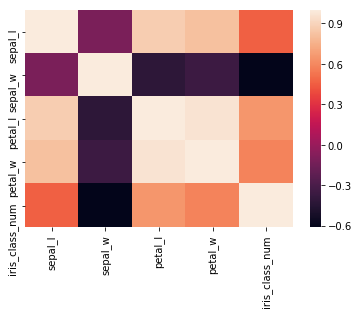

In [24]:
sns.heatmap(df.corr())

## Features and Label

In [25]:
FEATURES_NUM = ['sepal_l','sepal_w','petal_l','petal_w']
LABEL = 'iris_class_num'

## Split into dataset of: Train, Validation, Test (70%-20%-10%)

In [99]:
df_train0, df_valid0, df_test0 = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

# Obtain only featured columns
df_train = df_train0[['iris_class_num','sepal_l','sepal_w','petal_l','petal_w']]
df_valid = df_valid0[['iris_class_num','sepal_l','sepal_w','petal_l','petal_w']]
df_test = df_test0[['iris_class_num','sepal_l','sepal_w','petal_l','petal_w']]

print('Train set: {}'.format(df_train0.shape))
print('Validate set: {}'.format(df_valid0.shape))
print('Test set: {}'.format(df_test0.shape))

Train set: (105, 6)
Validate set: (30, 6)
Test set: (15, 6)


## Determine metrics for validation - Accuracy

In [100]:
def print_accuracy(model, df):
  metrics = model.evaluate(input_fn = tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    shuffle = False
      
  ))
  print('Accuracy on dataset = {}'.format(metrics['accuracy']))
    
#print_accuracy(model, df_valid)

## Model: DNNClassifier

In [102]:
# DNNClassifier
OUTDIR = 'irisClass_trained'
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model = tf.estimator.DNNClassifier(
    hidden_units = [4096, 512],
    feature_columns = [tf.feature_column.numeric_column('sepal_l'),
                       tf.feature_column.numeric_column('sepal_w'),
                       tf.feature_column.numeric_column('petal_l'),
                       tf.feature_column.numeric_column('petal_w')
                      ], 
    activation_fn = tf.nn.relu,
    n_classes=3,
    optimizer=tf.train.AdamOptimizer(
      learning_rate=0.0001
    ),
    model_dir = OUTDIR,
    config = tf.estimator.RunConfig()
)

model.train(input_fn = tf.estimator.inputs.pandas_input_fn(
    x = df_train,
    y = df_train[LABEL],
    batch_size = 128,
    num_epochs = 8,
    shuffle = True
  ));

print_accuracy(model, df_valid)

INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a27b81160>, '_is_chief': True, '_save_summary_steps': 100, '_device_fn': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_num_worker_replicas': 1, '_task_type': 'worker', '_model_dir': 'irisClass_trained', '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_train_distribute': None, '_service': None, '_log_step_count_steps': 100, '_session_config': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into irisClass_trained/model.ckpt.
INFO:tensorflow:loss = 139.75687, step = 1
INF

## Prediction

In [105]:
predictions = model.predict(input_fn = tf.estimator.inputs.pandas_input_fn(
#    x = pd.DataFrame({
#                      'Hour':[9,10,12],
#                      'Minute':[0,0,0],
#                      'IsoWeekday':[4,4,5]}),
    x = df_test,
    y = None,
    batch_size = 128,
    shuffle = False
  ))

for items in predictions:
  print(items)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from irisClass_trained/model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'probabilities': array([0.39789128, 0.25546366, 0.34664506], dtype=float32), 'classes': array([b'0'], dtype=object), 'logits': array([ 0.06438842, -0.3787102 , -0.07348903], dtype=float32), 'class_ids': array([0])}
{'probabilities': array([0.18544722, 0.40469384, 0.40985888], dtype=float32), 'classes': array([b'2'], dtype=object), 'logits': array([-0.6832802 ,  0.09708035,  0.10976238], dtype=float32), 'class_ids': array([2])}
{'probabilities': array([0.15344556, 0.46936408, 0.3771904 ], dtype=float32), 'classes': array([b'1'], dtype=object), 'logits': array([-0.834246  ,  0.28378695,  0.06515827], dtype=float32), 'class_ids': array([1])}
{'probabilities': array([0.11267672, 0.49322987, 0.3940934 ], dtype=float32), 'classes

In [104]:
df_test.head(30)

,iris_class_num,sepal_l,sepal_w,petal_l,petal_w
44,0,5.1,3.8,1.9,0.4
73,2,6.1,2.8,4.7,1.2
142,1,5.8,2.7,5.1,1.9
122,1,7.7,2.8,6.7,2.0
63,2,6.1,2.9,4.7,1.4
140,1,6.7,3.1,5.6,2.4
124,1,6.7,3.3,5.7,2.1
28,0,5.2,3.4,1.4,0.2
129,1,7.2,3.0,5.8,1.6
29,0,4.7,3.2,1.6,0.2
